# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255)

**Ознакомимся с датасетом**

In [ ]:
introductory_sample = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [ ]:
features, target = next(introductory_sample)
print(features.shape)
print(features[0])

(16, 224, 224, 3)
[[[0.5764706  0.5137255  0.454902  ]
  [0.53333336 0.47058827 0.41176474]
  [0.5294118  0.4666667  0.40784317]
  ...
  [0.48235297 0.4156863  0.30588236]
  [0.49411768 0.427451   0.31764707]
  [0.49803925 0.43137258 0.32156864]]

 [[0.5176471  0.454902   0.39607847]
  [0.5058824  0.4431373  0.38431376]
  [0.5529412  0.4901961  0.43137258]
  ...
  [0.49803925 0.43137258 0.32156864]
  [0.50980395 0.4431373  0.33333334]
  [0.50980395 0.4431373  0.33333334]]

 [[0.5176471  0.45098042 0.38823533]
  [0.5058824  0.43921572 0.37647063]
  [0.5176471  0.45098042 0.38823533]
  ...
  [0.5019608  0.43529415 0.3254902 ]
  [0.50980395 0.4431373  0.33333334]
  [0.5058824  0.43921572 0.32941177]]

 ...

 [[0.06666667 0.45882356 0.52156866]
  [0.08235294 0.47450984 0.5372549 ]
  [0.04705883 0.427451   0.49411768]
  ...
  [0.16078432 0.40784317 0.43529415]
  [0.12156864 0.36862746 0.39607847]
  [0.15294118 0.40000004 0.427451  ]]

 [[0.10196079 0.49411768 0.5568628 ]
  [0.06666667 0.458

Text(0, 0.5, 'Колличество людей')

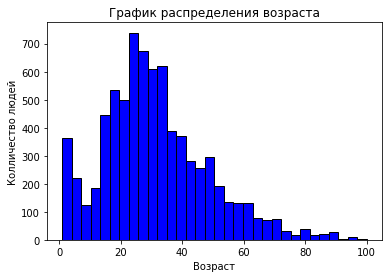

In [ ]:
plt.hist(labels['real_age'], color = 'blue', edgecolor = 'black',
         bins = 32)
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Колличество людей')

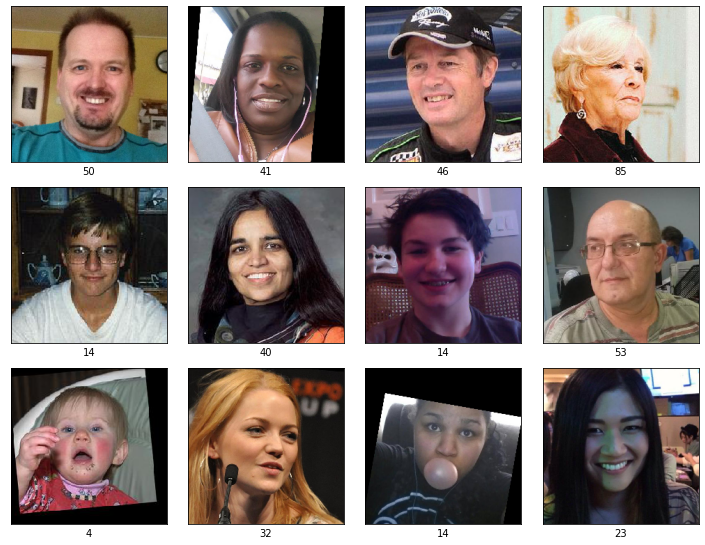

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])

    plt.xticks([])
    plt.yticks([])
    plt.xlabel(target[i])
    plt.tight_layout()

**Вывод**

График распределения возрастов показывает, что в датасете в основном фотографии людей примерно в диапозоне от 15 до 35 лет

Лица на фотографиях в датасете отцентрованы, это очень хорошо для обучения. Та же видно, что разметка возраста верная.

Общий вывод по датасету: В датасете достаточно фотографий для обученияю. Так же имеется высокая концентрация фотографий для определения совершеннолетия, что является второй задачей обучения

## Обучение модели

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.25, horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + '/final_files/'),
        target_size=(150, 150),
        batch_size=16,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + '/final_files'),
        target_size=(150, 150),
        batch_size=16,
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        classes=1)

    model = Sequential()
    optimizer = Adam(lr=0.0001)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss=MeanAbsoluteError(),
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


```

```


Train for 356 steps, validate for 119 steps
Epoch 1/15
2023-02-28 23:44:49.870763: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-28 23:44:50.187958: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 48s - loss: 10.7812 - mae: 10.7817 - val_loss: 20.5780 - val_mae: 20.5728
Epoch 2/15
356/356 - 36s - loss: 7.7415 - mae: 7.7420 - val_loss: 11.7194 - val_mae: 11.7199
Epoch 3/15
356/356 - 37s - loss: 6.9078 - mae: 6.9083 - val_loss: 7.1669 - val_mae: 7.1637
Epoch 4/15
356/356 - 38s - loss: 6.0086 - mae: 6.0088 - val_loss: 7.8176 - val_mae: 7.8093
Epoch 5/15
356/356 - 37s - loss: 5.4417 - mae: 5.4423 - val_loss: 6.9314 - val_mae: 6.9204
Epoch 6/15
356/356 - 36s - loss: 4.9017 - mae: 4.9023 - val_loss: 7.5162 - val_mae: 7.5278
Epoch 7/15
356/356 - 38s - loss: 4.6772 - mae: 4.6770 - val_loss: 7.0535 - val_mae: 7.0479
Epoch 8/15
356/356 - 37s - loss: 4.3533 - mae: 4.3531 - val_loss: 6.4747 - val_mae: 6.4807
Epoch 9/15
356/356 - 36s - loss: 4.0132 - mae: 4.0136 - val_loss: 6.5330 - val_mae: 6.5335
Epoch 10/15
356/356 - 36s - loss: 3.7066 - mae: 3.7065 - val_loss: 6.8420 - val_mae: 6.8458
Epoch 11/15
356/356 - 36s - loss: 3.4486 - mae: 3.4486 - val_loss: 6.3263 - val_mae: 6.3232
Epoch 12/15
356/356 - 36s - loss: 3.3399 - mae: 3.3397 - val_loss: 6.4509 - val_mae: 6.4498
Epoch 13/15
356/356 - 38s - loss: 3.2072 - mae: 3.2074 - val_loss: 6.4277 - val_mae: 6.4291
Epoch 14/15
356/356 - 38s - loss: 3.0507 - mae: 3.0505 - val_loss: 6.3542 - val_mae: 6.3568
Epoch 15/15
356/356 - 38s - loss: 2.9814 - mae: 2.9813 - val_loss: 6.2732 - val_mae: 6.2693
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.2732 - mae: 6.2693
Test MAE: 6.2693




```

## Анализ обученной модели

**Вывод**

На тестовой выборке удалось достичь MAE = 6.2693, что проходит по техническому заданию. Но при большем колличестве эпох и с более точной ностройкой параметров иожно повысить качество модели. Так же можно заметить переобучение модели, но для многослойный моделей это нормально.

**Рекомендации по дальнейшей работе модели**

Модель работает и определяет возраст покупателей, но на длительной дистанции качество предсказаний может упасть из-за морального устаревания данных, на которых обучалась модель. Рекомендую, со временем, дообучать модель на новых выборках, это должно решить проблему морального устаревания